<a href="https://colab.research.google.com/github/eric-castillo05/emotions-wheel-nlp/blob/main/TF_IDF_lreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("praveengovi/emotions-dataset-for-nlp")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotions-dataset-for-nlp


In [13]:
with open (path+'/train.txt', "r", encoding = "utf-8") as f:
    raw_data_train = f.readlines()

In [14]:
with open (path+'/test.txt', "r", encoding = "utf-8") as f:
    raw_data_test = f.readlines()

In [15]:
texts_train = []
labels_train = []

for text in raw_data_train:
  if ';' in text:
    t, l = text.strip().split(';')
    labels_train.append(l)
    texts_train.append(t)

In [16]:
texts_test = []
labels_test = []

for text in raw_data_train:
  if ';' in text:
    t, l = text.strip().split(';')
    labels_test.append(l)
    texts_test.append(t)

In [17]:
import polars as pl
import numpy as np

In [18]:
df_train = pl.DataFrame({'text': texts_train, 'label': labels_train})
df_test = pl.DataFrame({'text': texts_test, 'label': labels_test})

In [19]:
df_train.head()

text,label
str,str
"""i didnt feel humiliated""","""sadness"""
"""i can go from feeling so hopel…","""sadness"""
"""im grabbing a minute to post i…","""anger"""
"""i am ever feeling nostalgic ab…","""love"""
"""i am feeling grouchy""","""anger"""


In [20]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [21]:
def decontract(sentence):
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def removePunctuation(sentence):
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)
    sentence = sentence.strip()
    sentence = sentence.replace("\n"," ")
    return sentence

def removeNumber(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in sentence.split() if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

def stemming(sentence):
    stemmer = SnowballStemmer("english")
    stemmedSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemmedSentence += stem
        stemmedSentence += " "
    stemmedSentence = stemmedSentence.strip()
    return stemmedSentence

In [22]:
x_train, y_train = df_train.select('text').to_series().to_list(), df_train.select('label').to_series().to_list()
x_test, y_test = df_test.select('text').to_series().to_list(), df_test.select('label').to_series().to_list()

In [24]:
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
import spacy

In [25]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [26]:
nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])

In [27]:
from sklearn.preprocessing import normalize

def spacy_embeddings(texts):
    texts_processed = [decontract(t) for t in texts]
    docs = list(nlp.pipe(texts_processed, batch_size=50))
    vectors = np.array([doc.vector for doc in docs])
    return normalize(vectors, norm='l2')

In [30]:
def custom_preprocess(text):
    text = decontract(text)
    text = removePunctuation(text)
    text = removeNumber(text)
    text = removeStopWords(text)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    return ' '.join(lemmas)

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [31]:
feature_union = FeatureUnion([
    ("tfidf", TfidfVectorizer(
        preprocessor=custom_preprocess,
        ngram_range=(1, 2),
        max_features=8000,
        norm="l2"
    )),
    ("embeddings", FunctionTransformer(
        spacy_embeddings,
        validate=False
    ))
])

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
x_train = feature_union.fit_transform(x_train)
x_test = feature_union.transform(x_test)

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
le = LabelEncoder()

In [36]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [67]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

In [68]:
lreg = LogisticRegression(max_iter = 1000)

In [69]:
lreg.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [41]:
y_pred = lreg.predict(x_test)

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2159
           1       0.95      0.91      0.93      1937
           2       0.92      0.98      0.95      5362
           3       0.94      0.79      0.86      1304
           4       0.95      0.98      0.96      4666
           5       0.95      0.72      0.82       572

    accuracy                           0.94     16000
   macro avg       0.95      0.89      0.91     16000
weighted avg       0.94      0.94      0.94     16000



In [ ]:
import joblib

In [ ]:
joblib.dump(lreg, 'tdidf-logreg.pkl')

['tdidf-logreg.pkl']

In [ ]:
joblib.dump(feature_union, 'preproces-tfidf.pkl')

['preproces-tfidf.pkl']

In [73]:
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
joblib.dump(label_map, 'label_map.pkl')

['label_map.pkl']

# Confustion Matrix

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

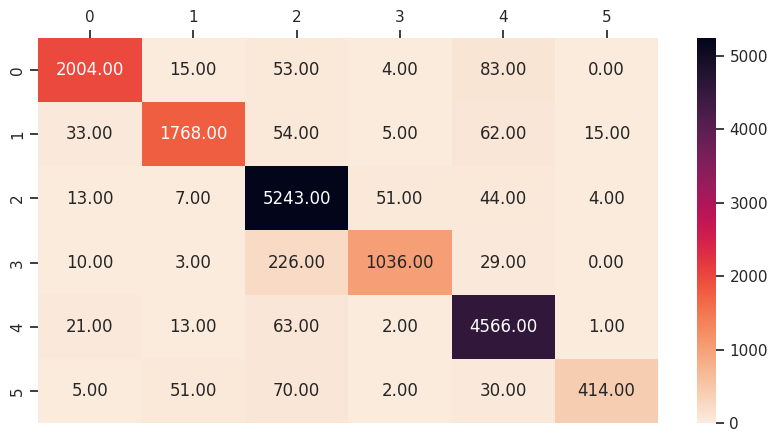

In [53]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), cmap = 'rocket_r', fmt = '.2f', annot = True)
ax.set(xlabel = '', ylabel = '')
ax.xaxis.tick_top()
plt.show()

# ROC Curve

In [4]:
import joblib

with open ('tdidf-logreg.pkl', 'rb') as f:
  lreg = joblib.load(f)

In [47]:
from sklearn.metrics import roc_curve, auc

In [80]:
label_map

{np.str_('anger'): np.int64(0),
 np.str_('fear'): np.int64(1),
 np.str_('joy'): np.int64(2),
 np.str_('love'): np.int64(3),
 np.str_('sadness'): np.int64(4),
 np.str_('surprise'): np.int64(5)}

In [90]:
list(label_map.keys())[2]

np.str_('joy')

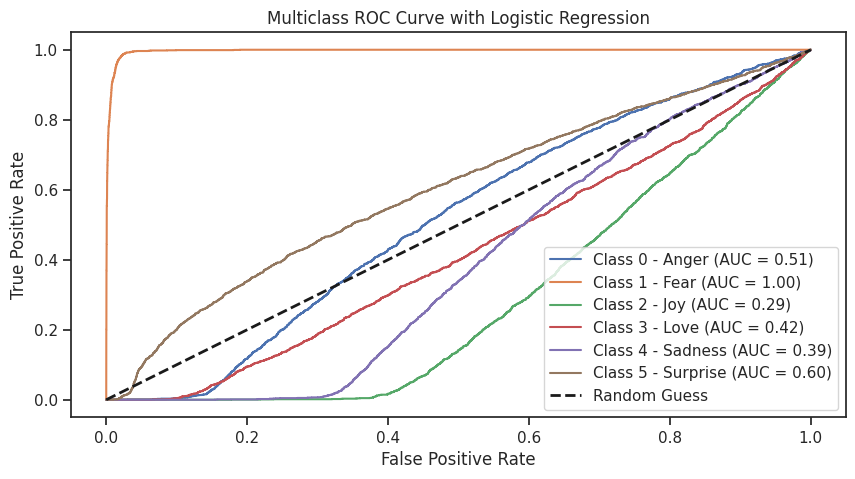

In [94]:
fpr = dict()
tpr = dict()
roc_auc = dict()
sns.set_theme(style = 'ticks')

y_score = lreg.predict_proba(x_test)
n_classes = len(lreg.classes_)

plt.figure(figsize = (10, 5))

for i in range(n_classes):
  y_true_binary = (y_test == 1).astype(int)
  y_score_binary = y_score[:, i]

  fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_score_binary)
  roc_auc[i] = auc(fpr[i], tpr[i])
  plt.plot(fpr[i], tpr[i], label = f'Class {i} - {list(label_map.keys())[i].title()} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw =  2, label = 'Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve with Logistic Regression')
plt.legend(loc = 'lower right')
plt.show()